# Question 3

Stitch together two given images using an affine transformation, and again using a homography

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy as sp
from skimage import color
import cv2


%matplotlib inline


In [2]:
# Question 3, helper functions

def getMatchingKeyPoints(im1, im2):
    '''
    Given two images, extracts keypoints for each and returns the matches with a ratio below 0.8
    '''
    # extract keypoints and their descriptors:
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(im1,None)
    kp2, des2 = sift.detectAndCompute(im2,None)
    
    
    matches = []  # keep track of best matches and the euclidian distances corresponding to the matches
    matches2 = []  # keep track of second best matches
    # each list above contains elements of the form [descriptor1, descriptor2, distance]
    
    matched_kp = []  # store locations of best matches for each keypoint
    # each element in the list above is of the form [keypoint1, keypoint2]
    
    # compare keypoints to find best and second best matches (from im2) for each keypoint in im1
    for im1_index in range(len(kp1)):
        best_match = None
        best_match2 = None
        min_dist = np.inf
        min_dist2 = np.inf
        best_index = None
        
        for im2_index in range(len(kp2)):
            dist = np.linalg.norm(des1[im1_index] - des2[im2_index])
            
            if dist <= min_dist:  # check if des2[im2_index] is best match so far for des1[im1_index]
                min_dist = dist
                best_match = des2[im2_index]
                best_index = im2_index
                
            elif dist <= min_dist2:  # check if it is the second best match so far
                min_dist2 = dist
                best_match2 = des2[im2_index]
                               
        matches.append([des1[im1_index], best_match, min_dist])
        matches2.append([des1[im1_index], best_match2, min_dist2])
        matched_kp.append([kp1[im1_index], kp2[best_index]])   
    

    good_matches = []
    
    # find matches with a ratio below 0.8       
    for i in range(len(matches)):
        ratio = np.abs(matches[i][2]/matches2[i][2])

        if ratio <= 0.8:
            good_matches.append(matched_kp[i])     
    
    return np.array(good_matches)




def getAffine(matches):  
    '''
    Given 3 pairs of matching keypoints from two images, return the affine transformation matrix that maps the keypoints
    from the first image to those of the second
    '''
    
    X = []  # keypoint coordinates of first image
    T = []  # target keypoint coordinates (ie. from second image)
    
    for kps in matches:
        X.append(kps[0].pt)
        T.append(kps[1].pt)

    X = np.array(X)
    T = np.array(T)

    # Solve for the affine transformation:

    # convert the matrix equation to the form given by slide 42 of lecture 8
    # go from AX = T to xa = t  (so now our unknown is a vector a)

    t = T.ravel()
    x = np.zeros((3,2,6))

    for i in range(3):
        x[i] = np.array([[X[i,0], X[i,1], 0, 0, 1, 0],
                         [0, 0, X[i,0], X[i,1], 0, 1]])
    x = x.reshape((6,6))    

    # solve for a
    a = np.linalg.solve(x, t)

    # now that we solved for a, reshape it to get the Affine transformation matrix A
    A = np.zeros((2,3))
    A[0,0] = a[0]
    A[0,1] = a[1]
    A[0,2] = a[4]
    A[1,0] = a[2]
    A[1,1] = a[3]
    A[1,2] = a[5]

    
    return A

def applyAffine(A, points):  #make one for homography as well
    '''
    given an affine transformation matrix, apply it to given points and return the resulting points
    '''
    
    transformed_points = np.zeros(np.shape(points))
    for i in range(len(points)):
        transformed_points[i] = np.matmul(A, np.concatenate((points[i], np.array([1])), axis=None))
        # Note: the concatenate is used to add a 1 to the vectors to get them in the desired form : [x, y, 1]
        # the matmul is to apply the affine transformation
    
    return transformed_points


def getHomography(matches):
    '''
    Given 4 pairs of matching keypoints from two images, return the homography transformation matrix that maps the keypoints
    from the first image to those of the second
    '''
    A = np.zeros((4,2,9))

    for i in range(4):
        x = matches[i, 0].pt[0]
        y = matches[i, 0].pt[1]
    
        x_prime = matches[i, 1].pt[0]
        y_prime = matches[i, 1].pt[1]


        A[i] = np.array([[x, y, 1, 0, 0, 0, -x*x_prime, -y*x_prime, -x_prime],
                         [0, 0, 0, x, y, 1, -x*y_prime, -y*y_prime, -y_prime]])
    A = A.reshape((8,9))    

    # solve for h
    # as per https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog,
    # h is the last singular vector of V, where A = US(V^T) (singular value decomposition, V^T is the transpose of V)

    u, s, v = np.linalg.svd(A, full_matrices=True)
    h = v[-1]


    # now that we solved for h, reshape it to get the homography transformation matrix H
    H = h.reshape((3,3))
    
    return H
    
def applyHomography(H, points):
    '''
    given homography transformation matrix, apply it to given points and return the resulting points
    '''
    
    new_points = np.zeros(np.shape(points))

    for i in range(len(points)):
        new_points[i] = np.matmul(H, np.concatenate((points[i], np.array([1])), axis=None))[:2]
    
    return new_points
    
def RANSAC(matches, n=20, thresh=2, method='affine'):
    '''
    Given list of matching keypoints between two images, choose 3 matches at random. Use these matches to compute an Affine 
    transformation (or homography), and apply the transformation to all keypoints from the first image. Then, compare the
    transformed keypoints from image 1 to their corresponding keypoints from image 2. If the distance between them is below
    thresh, count the pair as an inlier. Count the number of inliers for the transformation.
    
    Repeat the above process n times, and return the affine transformation (or homography) with the highest number of inliers
    
    
    matches: list where each element is of the form [keypoint1, keypoint2], where keypoint1 and keypoint2 are known to "match"
    n: number of iterations
    thresh: threshold for matches to be considered inliers of each transformation
    '''
    
    bestA = None  #  transformation matrix with most inliers
    most_inliers = 0  # to keep track of current maximum number of inliers
    
    # iterate n times
    for i in range(n):
    
        # Select 3 random matches
        indices = np.array([0, 0, 0])        
        
        if method=='affine':
            while indices[0]==indices[1] or indices[0]==indices[2] or indices[2]==indices[1]:
                indices = np.random.randint(len(matches), size=3)
        else:
            #TODO: need to ensure four different indices
            indices = np.random.randint(len(matches), size=4)
        
        rand_matches = matches[indices]
        
        if method=='affine':
            # Compute affine transformation matrix
            A = getAffine(rand_matches)
            
        else:
            # Compute homography transformation matrix
            A = getHomography(rand_matches)
        
        # apply transformation to keypoints from first image
        kp1 = []  # keypoints from first image
        kp2 = []  # keypoints from second image
        for m in matches:
            kp1.append(m[0].pt)
            kp2.append(m[1].pt)
        kp1, kp2 = np.array(kp1), np.array(kp2)
        
        if method=='affine':
            new_kp1 = applyAffine(A, kp1)  # applying transformation
        
        else:
            new_kp1 = applyHomography(A, kp1)
        
        
        # compare transformed points to their corresponding keypoints from second image and count number of inliers
        inliers = 0
        
        for p in range(len(new_kp1)):
            if np.linalg.norm(new_kp1[p] - kp2[p]) <= thresh:
                inliers +=1
        
        # update value of most_inliers if necessary, along with bestA
        if inliers >= most_inliers:
            bestA = A
            most_inliers = inliers
    
    return bestA
        
     
    


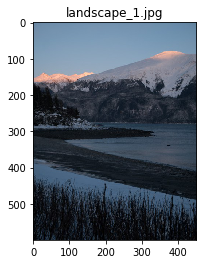

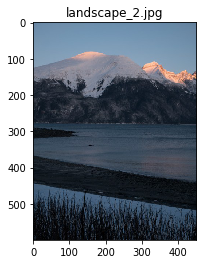

In [3]:
# Question 3

# read in images
im1 = cv2.imread('landscape_1.jpg')
im2 = cv2.imread('landscape_2.jpg')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

plt.imshow(im1)
plt.title('landscape_1.jpg')
plt.show()

plt.imshow(im2)
plt.title('landscape_2.jpg')
plt.show()
# get keypoint matches between images, with ratio < 0.8
matches = getMatchingKeyPoints(im2, im1)

# we choose the order im2, im1 because we want the transformation we find to shift to the right (since there are no negative
#   coordinates for images, shifts to the left take the image "off screen")
# Therefore, we want to shift im2 (to the right)



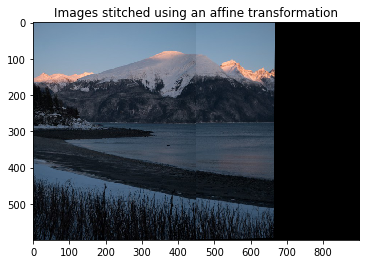

In [4]:
# Stitch using affine transformation


# get the affine transformation between the images
affine = RANSAC(matches, n=20, thresh=2, method='affine')

# stitch the images
cols = np.shape(im2)[0]
rows = np.shape(im2)[1]

# apply transformation to im2
warped_im = cv2.warpAffine(im2, affine, (2*rows, cols))


# "fill in" the remainder of the image with the unwarped image (im1) to complete the stitching process
warped_im[0:im1.shape[0], 0:im1.shape[1]] = im1


plt.imshow(warped_im)
plt.title("Images stitched using an affine transformation")
plt.show()


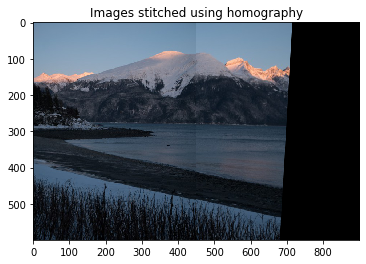

In [18]:
# stitch using homography

# get the homography transformation between the images
homography = RANSAC(matches, n=400, thresh=2, method='homography')
# stitch the images
cols = np.shape(im2)[0]
rows = np.shape(im2)[1]

# apply transformation to im2
warped_im2 = cv2.warpPerspective(im2, homography, (2*rows, cols))


# "fill in" the remainder of the image with the unwarped image (im1) to complete the stitching process
warped_im2[0:im1.shape[0], 0:im1.shape[1]] = im1


plt.imshow(warped_im2)
plt.title("Images stitched using homography")
plt.show()

I believe there is a bug somewhere in my homography
code, because although the affine transformation always results
in the same stitched image, the homography sometimes gives bad
results. However, when it works correctly, the homography gives much
better results than the affine transformation, (running the cell above until a good result is obtained shows the homography stitch is almost perfect).